In [11]:
import numpy as np 
import numpy.linalg as LA
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/daniel_vander-hyde/Documents/git/playground/cust_python')
import optimoe.tr_mat as opt
from optimoe.tr_mat import *
import scipy.io as sio
import scipy.signal as sig

In [12]:
#PRC params (imported from .mat file)
PRC_data = sio.loadmat('/Users/daniel_vander-hyde/Documents/MATLAB/PRC_rtgp_with_lensing/inputBeamParams.mat')

In [22]:
PRC_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Sep 30 21:17:21 2016',
 '__version__': '1.0',
 '__globals__': [],
 'IMC': array([[(array([[1.064e-06]]), array([[0.2325+13.38321221j]]), array([[4]], dtype=uint8), array([[16.2406, 16.2406,  0.2325,  0.2325,  0.    ]]), array([[0.07313684, 0.        , 0.        , 0.        ]]), array([[array(['MC2'], dtype='<U3'), array(['MC3'], dtype='<U3'),
         array(['Waist'], dtype='<U5'), array(['MC1'], dtype='<U3')]],
       dtype=object), array([[50]], dtype=uint8))]],
       dtype=[('lambda', 'O'), ('q', 'O'), ('N', 'O'), ('dist', 'O'), ('ifoc', 'O'), ('label', 'O'), ('Pin', 'O')]),
 'n': array([[1.44963]]),
 'epsilon3': array([[-0.0124833]]),
 'epsilon4': array([[0.03121929]]),
 'PeriscopeToViewport': array([[2.71]]),
 'f1': array([[9099451]], dtype=int32),
 'c': array([[299792458]], dtype=int32),
 'lambda': array([[1.064e-06]]),
 'RPRM': array([[-11]], dtype=int16),
 'RPR2': array([[-4.555]]),
 'RPR3': array([[36]],

In [13]:
#Length vars (also imported from .mat file)

L_Mto2 = opt.space(PRC_data['LPRM'].astype('float'))
L_2to3 = opt.space(PRC_data['LPR2'].astype('float'))
L_3toITM = opt.space(PRC_data['LPR3'].astype('float'))
L_3toBS = opt.space(19.538)

In [14]:
#Lens vars (some imported from .mat file, other information is from the alog)
pow_CO2 = .8 #CO2 power
o_n = 5 #order number
#Taken from alog 43632
alpha_CO2 = 25.0e-6 
fITM = PRC_data['fITM']
print(fITM)

if pow_CO2 == 0:
    fITM_tot =fITM
else: 
    opt_pow_ITM = pow_CO2*alpha_CO2
    fITM_therm = 1/opt_pow_ITM
    fITM_tot = (fITM*fITM_therm)/(fITM + fITM_therm) 

[[-4312.43466851]]


In [15]:
#Mirror vars (imported from the .mat file)
cmirror_PR2 = opt.cmirror(PRC_data['RPR2'].astype('float'))
cmirror_PR3 = opt.cmirror(PRC_data['RPR3'].astype('float'))
lens_ITM = opt.lens(fITM_tot)
lens_ITM_cold = opt.lens(PRC_data['fITM'].astype('float'))
cmirror_PRM = opt.cmirror(PRC_data['RPRM'].astype('float'))
cmirror_ITM = opt.cmirror(-1*PRC_data['RITM'].astype('float'))

In [16]:
PRC_RT_cold = cmirror_PRM*L_Mto2*cmirror_PR2*L_2to3*cmirror_PR3*L_3toITM*lens_ITM_cold*cmirror_ITM*lens_ITM_cold*L_3toITM* \
              cmirror_PR3*L_2to3*cmirror_PR2*L_Mto2 
PRC_RT_hot = cmirror_PRM*L_Mto2*cmirror_PR2*L_2to3*cmirror_PR3*L_3toITM*lens_ITM*cmirror_ITM*lens_ITM*L_3toITM* \
             cmirror_PR3*L_2to3*cmirror_PR2*L_Mto2

In [18]:
gp_cold = opt.rt_gouy(PRC_RT_cold.astype('float'))
gp_hot = opt.rt_gouy(PRC_RT_hot.astype('float'))


In [21]:
gp_cold*180/(np.pi)

50.09161245898397

In [174]:
FSR = 299792458/(2*(PRC_data['LPRC'][0][0]))
freq = np.arange(FSR, 2.5*FSR, 1.5*FSR/100000)
ind = range(len(freq))
fines = 114.0
nu_tms_cold = FSR*(gp_cold/(2*np.pi))
nu_tms_hot = FSR*(gp_hot/(2*np.pi))

In [175]:
# Power resonating in the cavity
def P_circ(nu, fines, fsr, P_max=1): 
    P = P_max/((1 +pow((2.0*fines/np.pi),2)*pow(np.sin((np.pi*nu)/fsr),2)))
    return P

In [176]:
P = [P_circ(i, fines, FSR) for i in freq] 
P_HOM_cold = [P_circ(i, fines, FSR + o_n*nu_tms_cold) for i in freq]
P_HOM_hot = [P_circ(i, fines, FSR + o_n*nu_tms_hot) for i in freq]

In [177]:
max_ind_cold = sig.find_peaks(P_HOM_cold)[0][0]
max_ind_hot = sig.find_peaks(P_HOM_hot)[0][0]

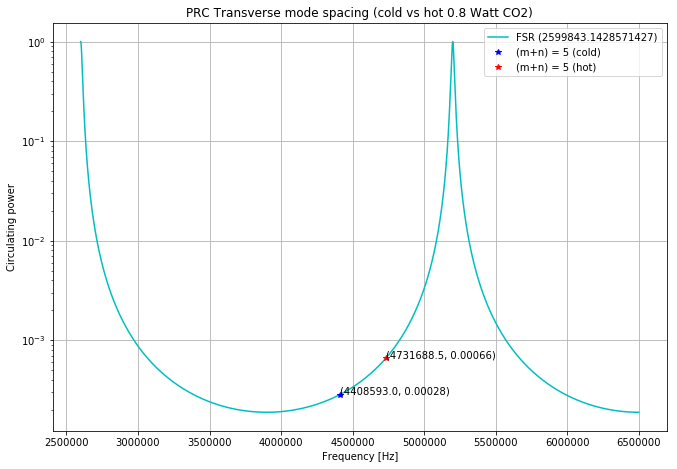

In [178]:
f = plt.figure(figsize=(11,7.5))
plt.semilogy(freq,P,'c')
#plt.semilogy(freq,P_HOM_cold,'r')
plt.semilogy(freq[max_ind_cold],P[max_ind_cold],'b*')
plt.semilogy(freq[max_ind_hot], P[max_ind_hot], 'r*')
plt.annotate('({}, {})'.format(round(freq[max_ind_cold],1),round(P[max_ind_cold],5)), xy=(freq[max_ind_cold],P[max_ind_cold]))
plt.annotate('({}, {})'.format(round(freq[max_ind_hot],1),round(P[max_ind_hot],5)), xy=(freq[max_ind_hot],P[max_ind_hot]))
plt.title('PRC Transverse mode spacing (cold vs hot {} Watt CO2)'.format(pow_CO2))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Circulating power')

plt.legend(('FSR ({})'.format(FSR), '(m+n) = {} (cold)'.format(o_n), '(m+n) = {} (hot)'.format(o_n)), loc='best')

plt.grid()
plt.show()

In [ ]:
f.savefig('cav_tms_out.pdf',bbox_inches='tight')